In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def lin_func(x, a):
    return a * x

In [6]:
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'pdk_thermphase_test_cells'

no = 0
data_dir_gen = sorted(data_path.glob(f'reticle27/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    # print(df['wavelength'])
    # ret = int(df['reticle'][0])
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]

currs = [i - currs[0] for i in currs] # current should be 0 at 0 V
currs_mA = np.multiply(currs, 1000)

elec_pwrs = np.multiply(volts, currs_mA)
res = np.divide(volts[1:], currs[1:])

print(currs_mA)
print(res)

[ 0.         3.3686129  6.6816479 10.0338529 13.1065349 16.1177149
 18.9996649 21.7279849 24.3848649 26.7950249 29.0504849 31.1634749
 33.1287249 35.0170849 36.7132049 38.2928849 39.7563349 41.1154649
 42.3817249 43.5897849 44.6491449 45.5970849 46.1244649 36.7135749
 34.0966849 32.7184249]
[29.68580925 29.93273561 29.89878395 30.51912676 31.02176724 31.57950433
 32.21651723 32.80723528 33.58832482 34.42283333 35.29773247 36.2223419
 37.12473507 38.13341831 39.17176791 40.24515851 41.34697258 42.47113595
 43.58819399 44.793691   46.0555758  47.6970303  62.64712729 70.38807459
 76.40954623]


(1310.0, 1317.5)

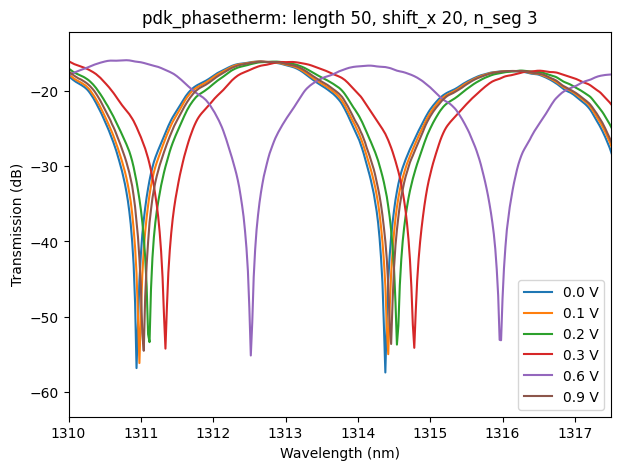

In [7]:
# plot tranmission spectra at different voltages
title = f"pdk_phasetherm: length {df['length'][no]}, shift_x {df['shift_x'][no]}, n_seg {df['n_seg'][no]}"
xlim = [1310, 1315.1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in [0,1,2,3,6,9]:
    ax.plot(wavel, trans[i], label=f'{volts[i]:.2} V')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Transmission (dB)')
ax.set_title(title)
ax.legend()
ax.set_xlim([1310, 1317.5])
# ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

3.4327788512021016
[[1310.9464790638224, 1314.3792579150245], [1310.981495532469, 1314.4150971241033], [1311.1098934606423, 1314.5465585246347], [1311.3398949308016, 1314.7815916852633], [1311.6407722840008, 1315.0799439995485], [1312.0431344930728, 1315.4828560159253], [1312.5201717964921, 1315.9680350115168], [1313.085066126989, 1316.5352262117444], [1310.3250030685654, 1313.7431124377333, 1317.1944065810512], [1311.0323888011312, 1314.452630178112]]


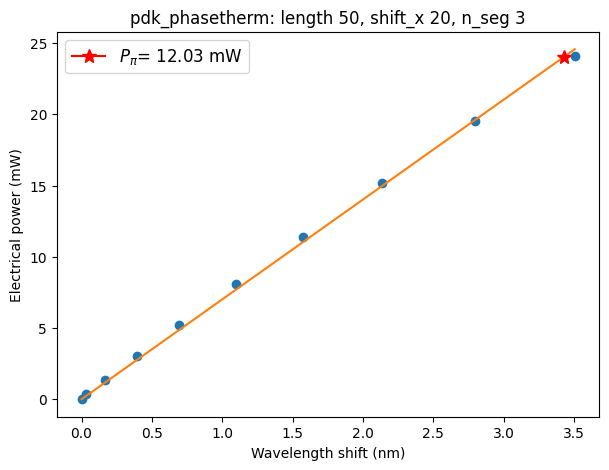

In [8]:
# Calculate FSR
# wavel[950] -> 1309 nm, wavel[1300] -> 1316 nm
l_id, u_id = find_index(1310, wavel), find_index(1317.5, wavel)
v_u_id = 10

dips_0V = find_dips(wavel[l_id:u_id], trans[0][l_id:u_id], -40)
FSR = dips_0V[1] - dips_0V[0]
wavel_ref = dips_0V[0]
print(FSR)

dips = []
for i in range(v_u_id):
    dips.append(find_dips(wavel[l_id:u_id], trans[i][l_id:u_id], -40))
print(dips)

dip = []
for i in range(v_u_id):
    # print(i)
    # print(dip)
    if i == 0:
        dip.append(dips[0][0])
        continue
    for d in dips[i]:
        if d > dip[i-1]:
            dip.append(d)
            break
            
wavel_shift = np.array([w - dip[0] for w in dip])
p_opt, p_cov = curve_fit(lin_func, wavel_shift, elec_pwrs[:v_u_id])
P_pi = lin_func(FSR, *p_opt)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(wavel_shift, elec_pwrs[:v_u_id], 'o')
ax.plot(wavel_shift, lin_func(wavel_shift, *p_opt))
ax.plot(FSR, P_pi, marker='*', markersize=10, color='r', label='$P_{\pi}$' + f'= {P_pi/2:.2f} mW')
ax.set_ylabel('Electrical power (mW)')
ax.set_xlabel('Wavelength shift (nm)')
ax.set_title(title)
ax.legend(prop={'size':12})
# ax.set_xlim([1309, 1316])